# Projet phylogénétique
Théophile Sanchez (theophile.sanchez@inria.fr) - Sarah Cohen Boulakia

------

## Introduction

Au cours de ce projet, vous étudierez trois espèces disparues de félins qui vivaient autrefois sur le continent Américain. Ces trois espèces, le _smilodon_ (tigre à dents de sabre), l'_homotherium_ (_scimitar toothed tigers_) et _M. trumani_ (guépard américain) se sont éteintes il y a environ 13 000 ans, à la fin de la dernière période glaciaire. Des séquences ADN partielles de la protéine cytochrome b de ces espèces ont pu être séquencées et vont vous permettre de retrouver les liens de parentés entre ces espèces et des espèces de félins contemporaines : le chat domestique, le lion, le léopard, le tigre, le puma, le guépard et les chats sauvages africains, chinois et européens. Sont aussi présentes dans le jeu de donnée des séquences issues d'espèces extérieures aux félins.

Afin de reconstruire l'arbre phylogénétique de ces espèces, vous utiliserez une méthode basée sur le calcul des distances évolutives entre les séquences ADN des protéines. Sachez qu'une démarche similaire peut-être appliquée aux séquences d'acides aminés.

Les différentes étapes qui vous permetterons de construire l'arbre sont détaillées dans ce notebook. Vous devrez implémenter les algorithmes en Python et répondre aux questions dans les cellules prévues.

Quelques conseils :
- Utiliser au maximum les fonctions présentes dans les packages de python (sauf si il vous est explicitement demandé de les réimplémenter). Si un problème vous paraît courant, il existe surement déjà une fonction pour le résoudre. Pour ce projet vous serez limité aux packages de base, à Numpy et ETE (seulement pour l'affichage des arbres).
- Si une partie de votre code ne vous semble pas très explicite, ajoutez des commentaires pour l'expliquer. Une personne qui lit votre code doit pouvoir comprendre son fonctionnement facilement.
- N'hésitez pas à chercher dans la documentation et sur internet. Cependant, faites attention au plagiat !

Le projet est à rendre **en binôme** par mail. Vous regrouperez votre notebook et les fichiers nécessaires à son fonctionnement dans une archive portant vos noms et prénoms.

------
## Importation des séquences

Le format FASTA permet de stocker plusieurs séquences (ADN, ARN ou peptidiques) dans un fichier. Les séquences que vous allez étudier ont été regroupées dans le fichier `cat_dna.fasta`.

**Exercice 1 :** Écriver une fonction permettant d'importer un fichier au format fasta et de le stocker dans un dictionnaire. Les clés seront les noms des séquences et les valeurs du dictionnaire seront les séquences d'adn.

In [85]:
# À remplir
resultat = {}
def exercice1 (nom_fichier):
    fichier= open(nom_fichier,'r')
   
    L1= fichier.readlines()
    seq=[]
    for i in range(len(L1)) :
        #on recupère le nom de l'animal et on le met dans la clé (sans '>' et sans '\n')
        if L1[i][0]=='>':
            cle = L1[i].split('>')[1]
            cle = cle.split('\n')[0]
           # print(cle)
        #on a recupéré toutes les lignes avec la sequence d'ADN donc on peut la mettre dans le dictionnaire
        elif L1[i][0]== '\n':
            #on concatene toutes les ligne de la sequence d'ADN
            f=''
            for s in seq :
                f +=s 
            resultat[cle]=f
            seq=[]
        #on recupere toutes les lignes qui contiennent la sequence d'ADN de l'animal 'clé'
        else :
            s = L1[i].split('\n')[0]
            seq.append(s)
            #print(seq)
    #assert resultat['Felis Cat A DNA']=='CCCTTACCAAAATTATTAATCACTCATTCATCGACCTACCTGCCCCATCTAACATCTCAGCATGATGAAACTTCGGCTCCCTTCTAGGAGTCTGCCTAATCTTACAAATCCTCACCGGCCTCTTTTTGGCCATACACTACACATCAGACACAACAACCGCCTTTTCATCAGTTACCCACATCTGTCGCGACGTTAATTATGGCTGAATCATCCGATATTTACACGCCAACGGAGCTTCTATATTCTTTATCTGCCTGTACATACATGTAGGACGGGGAATATACTACGG'
    #print(resultat)
    fichier.close()
    
exercice1("cat_dna.fasta")



------
## Alignement des séquences

La méthode que vous utiliserez pour calculer l'arbre phylogénétique nécessite de calculer la distance évolutive entre les séquences. Avant de pouvoir les calculer, il faut d'abord aligner les séquences en considérant trois types de mutations :
- les substitutions (un nucléotide est remplacé par un autre)
- les insertions
- les délétions
Par exemple, les séquences "ACTCCTGA" et "ATCTCGTGA" ont plusieurs alignements possibles : 

$A_1$ :
```
-ACTCCTGA
ATCTCGTGA
```

$A_2$ :
```
A-CTCCTGA
ATCTCGTGA
```

$A_3$ :
```
AC-TCCTGA
ATCTCGTGA
```
.

.

.

Le "-" désigne un *gap*, c'est à dire un "trou" dans l'alignement qui a été causé par une insertion ou une déletion. On regroupe ces deux types de mutations sous le terme indel.

Ces alignements correspondent à une multitude d'histoires phylogénétiques différentes. Pour sélectionner le meilleur alignement il faut donc introduire l'hypothèse du maximum de parcimonie qui privilégie l'histoire phylogénétique qui implique le moins d'hypothèses et donc, le moins de changements évolutifs. Par exemple, parmis les trois alignements ci-dessus on preferera l'alignement 2 car il correspond au scénario avec le moins de mutations:
- l'alignement 1 implique au minimum 1 indel et 2 substitutions
- l'alignement 2 implique au minimum 1 indel et 1 substitutions
- l'alignement 3 implique au minimum 1 indel et 2 substitutions

On peut maintenant définir un score d'identité que l'on va augmenter de 1 lorsque qu'il n'y pas eu de mutation et ainsi obtenir la matrice suivante :

|   &nbsp;   | A | C | G | T | - |
|   -   | - | - | - | - | - |
| **A** | 1 | 0 | 0 | 0 | 0 |
| **C** | 0 | 1 | 0 | 0 | 0 |
| **G** | 0 | 0 | 1 | 0 | 0 |
| **T** | 0 | 0 | 0 | 1 | 0 |
| **-** | 0 | 0 | 0 | 0 | 0 |

Cette matrice correspond au modèle d'évolution de l'ADN défini par Jukes et Cantor qui fait l'hypothèse d'un taux de mutation équivalent pour chacun des nucléotides. Cependant, en réalité ces taux ne sont pas les mêmes partout, on sait par exemple que le taux de transition (substitution A$\leftrightarrow$G ou C$\leftrightarrow$T) est différent du taux de transversions (substitution A$\leftrightarrow$T, C$\leftrightarrow$G, C$\leftrightarrow$A ou G$\leftrightarrow$T) et que d'autres facteurs devrait être pris en compte comme la fréquence du nucléotide dans l'ADN. [C'est pour cette raison qu'il existe beaucoup de modèles différents d'écrivant l'évolution de l'ADN.](https://en.wikipedia.org/wiki/Models_of_DNA_evolution) Dans la suite de ce projet nous utiliserons la matrice de similarité $S$ suivante : 

|   &nbsp;   | A  | C  | G  | T  | -  |
|   -   | -  | -  | -  | -  | -  |
| **A** | 10 | -1 | -3 | -4 | -5 |
| **C** | -1 | 7  | -5 | -3 | -5 |
| **G** | -3 | -5 | 9  | 0  | -5 |
| **T** | -4 | -3 | 0  | 8  | -5 |
| **-** | -5 | -5 | -5 | -5 | -5 |

**Exercice 2 :** Écriver la fonction permettant de calculer le score entre deux alignements avec la matrice de similarité précédente puis afficher le score des trois alignements $A_1$, $A_2$ et $A_3$. La classe permettant d'importer une matrice et de calculer le score entre deux lettres vous est déjà fournie, la matrice de similarité est stockée dans le fichier `dna_matrix` :


In [86]:
import numpy as np


class SimilarityMatrix:
    def __init__(self, filename):
        with open(filename) as f:
            self.letters = f.readline().split()
            self.values = np.loadtxt(filename, skiprows=1, usecols=range(1, len(self.letters) + 1))
        
    def score(self, letter1, letter2): # return the similarity score between letter1 and letter2
        return self.values[self.letters.index(letter1)][self.letters.index(letter2)]
    
# Example
similarity_matrix = SimilarityMatrix('dna_matrix')
print('Score between G and C:', similarity_matrix.score('G', 'C'))
print('Score between A and a gap:', similarity_matrix.score('-', 'A'))

Score between G and C: -5.0
Score between A and a gap: -5.0


In [87]:
# À remplir
def score_align (A1,A2):
    similarity_matrix = SimilarityMatrix('dna_matrix')
    score_vec=0
    for i in range(len(A1)):
        score_vec+=similarity_matrix.score(A1[i], A2[i])
    return score_vec
print('score de A1 =',score_align('-ACTCCTGA','ATCTCGTGA'))
print('score de A2 =',score_align('A-CTCCTGA','ATCTCGTGA'))
print('score de A3 =',score_align('AC-TCCTGA','ATCTCGTGA'))

score de A1 = 35.0
score de A2 = 49.0
score de A3 = 39.0


------
### Algorithme de Needleman-Wunsch

Maintenant que vous avez vu ce qu'est une matrice de similarité et comment calculer le score de similarité d'un alignement, vous allez devoir implémenter un algorithme permettant de trouver le meilleur alignement global entre deux séquences. Avec deux séquences à aligner de taille $n$ et $m$, la première étape consiste à initialiser deux matrices de taille $(n+1) \times (m+1)$. La première est la matrice de score $M$ et la seconde sera la matrice de *traceback* $T$. 

Par exemple, avec la matrice $S$ et les séquences $A =$ "ACTCCTGA" et $B =$ "ATCTCGTGA", on initialise $M$ comme si l'on ajoutait des *gaps* partout :

|   &nbsp;   | - | A | T | C | T | C | G | T | G | A |
|   -   | - | - | - | - | - | - | - | - | - | - |
| **-** | 0 |-5 |-10|-15|-20|-25|-30|-35|-40|-45|
| **A** |-5 | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **C** |-10| &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **T** |-15| &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **C** |-20| &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **C** |-25| &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **T** |-30| &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **G** |-45| &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **A** |-40| &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; ||

Puis on initialise $T$ :

|   &nbsp;   | - | A | T | C | T | C | G | T | G | A |
|   -   | - | - | - | - | - | - | - | - | - | - |
| **-** | o | l | l | l | l | l | l | l | l | l |
| **A** | u | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **C** | u | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **T** | u | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **C** | u | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **C** | u | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **T** | u | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **G** | u | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **A** | u | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; ||


Il faut ensuite remplir la matrice $M$ en suivant la formule $M_{ij} = \max(M_{i-1j-1} + s(A_i, B_j), M_{ij-1} + s(A_i, gap), M_{i-1j} + s(B_j,gap) )$ avec $i \in {2, \dots, n+1}$, $j \in {2, \dots, m+1}$ et la fonction $s$ qui calcule le score de similarité entre deux nucléotides. Pour chaque case de $T$ on remplie par :
- 'd' (*diagonal*) si $M_{ij}$ a été calculé en utilisant la diagonale $M_{i-1j-1}$,
- 'l' (*left*) si $M_{ij}$ a été calculé en utilisant la case de gauche $M_{ij-1}$,
- 'u' (*up*) si $M_{ij}$ a été calculé en utilisant la case du haut $M_{i-1j}$.

On obtient alors les matrices suivantes $M$ et $T$ : 

|   &nbsp;   | - | A | T | C | T | C | G | T | G | A |
|   -   | - | - | - | - | - | - | - | - | - | - |
| **-** |  0| -5|-10|-15|-20|-25|-30|-35|-40|-45|
| **A** | -5| 10|  5|  0| -5|-10|-15|-20|-25|-30|
| **C** |-10|  5|  7| 12|  7|  2| -3| -8|-13|-18|
| **T** |-15|  0| 13|  8| 20| 15| 10|  5|  0| -5|
| **C** |-20| -5|  8| 20| 15| 27| 22| 17| 12|  7|
| **C** |-25|-10|  3| 15| 17| 22| 22| 19| 14| 11|
| **T** |-30|-15| -2| 10| 23| 18| 22| 30| 25| 20|
| **G** |-35|-20| -7|  5| 18| 18| 27| 25| 39| 34|
| **A** |-40|-25|-12|  0| 13| 17| 22| 23| 34| 49|

|   &nbsp;   | - | A | T | C | T | C | G | T | G | A |
|   -   | - | - | - | - | - | - | - | - | - | - |
| **-** | o | l | l | l | l | l | l | l | l | l |
| **A** | u | d | l | l | l | l | l | l | l | d |
| **C** | u | u | d | d | l | d | l | l | l | l |
| **T** | u | u | d | l | d | l | l | d | l | l |
| **C** | u | u | u | d | l | d | l | l | l | l |
| **C** | u | u | u | d | d | d | d | d | l | d |
| **T** | u | u | d | u | d | l | d | d | l | l |
| **G** | u | u | u | u | u | d | d | u | d | l |
| **A** | u | d | u | u | u | d | u | d | u | d |

Il suffit maintenant de regarder le dernier élément $M_{nm} = 49$ pour avoir le score de l'alignement. Pour avoir l'alignement lui-même, il faut partir de $T_{nm}$ et remonter la "trace" jusqu'à arriver au 'o'. Un 'd' correspond à un *match* entre les deux séquences, 'l' à un *gap* dans la séquence $A$ et 'u' à un *gap* dans la séquence $B$. En revenant à l'exemple précédent on obtient la trace suivante :

|   &nbsp;   | - | A | T | C | T | C | G | T | G | A |
|   -   | - | - | - | - | - | - | - | - | - | - |
| **-** | o | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **A** | &nbsp; | d | l | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **C** | &nbsp; | &nbsp; | &nbsp; | d | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **T** | &nbsp; | &nbsp; | &nbsp; | &nbsp; | d | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **C** | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | d | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **C** | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | d | &nbsp; | &nbsp; | &nbsp; |
| **T** | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | d | &nbsp; | &nbsp; |
| **G** | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | d | &nbsp; |
| **A** | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | d |

Elle correspond à l'alignement :
```
A-CTCCTGA
ATCTCGTGA
```

**Exercice 3 :** Implémenter l'algorithme de Needlman et Wunsch. Il prendra en paramètre deux séquences et une matrice de similarité et retournera leur alignement. Tester le avec les séquences "ACTCCTGA" et "ATCTCGTGA".

In [88]:
# À remplir
def algo_NW (S, A1, A2):
    t1 =len(A1)
    t2 = len(A2)
    M=np.zeros((t1+1,t2+1))
    T=np.full((t1+1,t2+1), '')
    #initialise M et T a la case (0,0) 
    M[0][0]=S.score('-','-')
    T[0][0]='o'
    #initialise la 1ere ligne de M et T  
    for i in range (1,t2+1):
        M[0][i] = M[0][i-1]+S.score('-',A2[i-1]) 
        T[0][i] = 'l'
    #initialise la 1ere colonne de M et T  
    for i in range (1,t1+1):
        M[i][0] = M[i-1][0]+S.score('-',A1[i-1])
        T[i][0] = 'u'
    #calcule le reste des matrices
    for i in range(1,t1+1):
        for j in range(1,t2+1):
            cas1 =M[i-1][j-1]+S.score(A1[i-1],A2[j-1])
            cas2 =M[i][j-1]+S.score(A1[i-1],'-')
            cas3 =M[i-1][j]+S.score('-',A2[j-1])
            M[i][j]= max( cas1,cas2,cas3)
            if  M[i][j]== cas1 :
                 T[i][j]='d'
            if  M[i][j]== cas2 :
                 T[i][j]='l'
            if  M[i][j]== cas3 :
                 T[i][j]='u'
    #calcule de l'alignement
    align = Lire_T(T, A1,A2)
    return (align)

def Lire_T(T,A1,A2):
    a1 = []
    a2 = []
    trace = []
    i,j = T.shape
    i-=1
    j-=1
    #on recupere le chemin
    while T[i][j]!= 'o':
        trace.append(T[i][j])
        if T[i][j]== 'l':
            j= j-1
        elif T[i][j]== 'u':
            i = i-1
        elif T[i][j]== 'd':
            i=i-1
            j=j-1      
    #on fait l'alignement    
    i,j = T.shape
    i-=2
    j-=2
    #print(len(A1),len(A2))
    #print(i,j)
    for k in range(len(trace)) : 
        if trace[k] =='d':
            a1.append(A1[i])
            a2.append(A2[j])
            i=i-1
            j=j-1
            
        elif trace[k] =='u':
            a2.append('-')
            a1.append(A1[i])
            i-=1
        elif trace[k] =='l':
            a1.append('-')
            a2.append(A2[j])
            j-=1
        #print(i,j)
    a1.reverse()
    a2.reverse()
    return(a1,a2)
    

A1='ACTCCTGA'
A2='ATCTCGTGA'
S=SimilarityMatrix('dna_matrix')
algo_NW (S, A1, A2)


(['A', '-', 'C', 'T', 'C', 'C', 'T', 'G', 'A'],
 ['A', 'T', 'C', 'T', 'C', 'G', 'T', 'G', 'A'])

----
## Matrice de distance

Dans le cas de séquences très proches, on estime que la distance évolutive réelle entre les séquences est proche de la p-distance qui est simplement le nombre de substitution dans l'alignement sur le nombre total de nucléotide. Pour simplifier, on ignore les positions alignées à des gaps. On applique ensuite la correction de Jukes-Cantor afin de prendre en compte le phénomène de saturation (un même site peut muter plusieurs fois au cours du temps). Sa formule est $-(\frac{3}{4})\ln(1-(\frac{4}{3})\times \textit{p-distance})$.

**Exercice 4 :** Implémenter la fonction retournant la matrice de distance à partir d'un dictionnaire de séquences. 

In [89]:
# À remplir
def mat_distance(D):
    M=np.zeros((len(D), len(D)))
    cpt=0
    for cle in D.keys():
        cpt2=0
        for cle2 in D.keys():
            if cpt <= cpt2:      #on fait une matrice triangle pour limiter le nombre de calcul
                M[cpt][cpt2]=0
            else:
                dist = 0
                gap  = 0
                #print(len(D.get(cle)))
                #print(len(D.get(cle2)))
                a,b = algo_NW (S, D.get(cle), D.get(cle2))#on recupere l'alignement
                for i in range(len(a)) :
                    if a[i] != b[i] :
                        if a[i]!='-' and b[i]!='-' :
                        #on compte le nombre de substitution
                           dist+=1
                        if a[i]=='-' or b[i]=='-':
                            gap +=1
                p_dist = dist/(len(a)-gap)
                #print(p_dist)
                cal =-(3/4)*np.log(1-((4/3)*p_dist))
                #print(cal)
                M[cpt][cpt2]=cal
                
            cpt2+=1
        cpt+=1
            
    return (M)

print(mat_distance(resultat))


[[ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.        ]
 [ 0.15108805  0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.        ]
 [ 0.12673751  0.10243165  0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.        ]
 [ 0.01406841  0.13939604  0.1170713   0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.        ]
 [ 0.1170713   0.12163124  0.11606117  0.10976731  0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0

------
## Construction d'un arbre avec UPGMA

Grâce aux mesures de distances entre les séquences, on peut maintenant de construire l'arbre phylogénétique des globines. Vous allez devoir pour cela implémenter l'algorithme UPGMA (*unweighted pair group method with arithmetic mean*) qui, malgré son nom compliqué, est l'une des méthodes les plus simples pour la construction d'arbre.

### Le format Newick

Le format Newick est l'un des formats utilisé en phylogénie pour représenter un arbre sous la forme d'une chaine de caractère. Le principe est simple, les groupes ayant la même racine sont écrit entre parenthèses et séparés par des virgules. Un groupe peut être soit une feuille de l'arbre (dans notre cas une séquence), soit un autre groupe. La longueur de la branche de chaque groupe est écrite après un double point et l'arbre est terminé par un point virgule. Pour afficher l'arbre on peut utiliser les fonction du package ETE : 

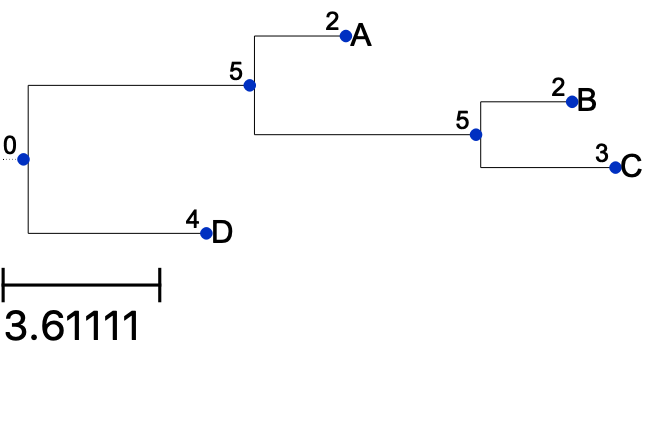

In [90]:
[{from ete3 import Tree, TreeStyle

newick_tree = '((A:2,(B:2,C:3):5):5,D:4);'
t = Tree(newick_tree)
ts = TreeStyle()
ts.show_branch_length = True
t.render('%%inline', w=183, units='mm', tree_style=ts)}][]

**Exercice 5 :** Reécriver l'arbre suivant au format Newick puis afficher-le. Les nombres correspondent aux longueurs des branches :
![](tree.png)

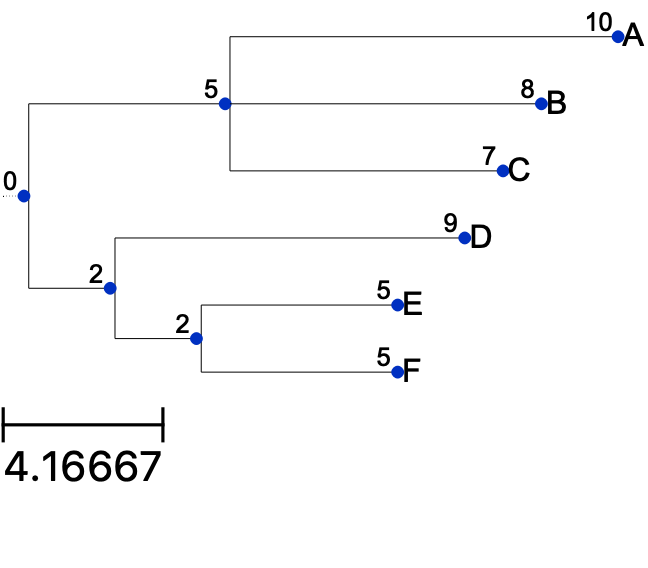

In [91]:
newick_tree = '((A:10,B:8,C:7):5,(D:9,(E:5,F:5):2):2);'
t = Tree(newick_tree)
ts = TreeStyle()
ts.show_branch_length = True
t.render('%%inline', w=183, units='mm', tree_style=ts)

**Exercice 6 :** Expliquer la relation de parenté entre $A$, $B$ et $C$ ? Qu'elles sont les hypothèses qui pourraient expliquer ce type d'embranchement dans un arbre ? Donner une réponse détaillée.

Réponse :A, B et C ont un ancetre commun mais il nous manque des informations sur un ancetre commun potentiel entre deux des trois especes (pour qu'on est un embranchement de type D,E,F).

### UPGMA

L'algorithme UPGMA se base sur la matrice de distance entre les séquences. À chaque itération, les séquences avec la distance la plus faible sont regroupées puis une nouvelle matrice de distance est calculée avec le nouveau groupe. Cette étape est répétée jusqu'à n'avoir plus qu'un seul groupe. Par exemple, avec la matrice de distance entre les séquences $A$, $B$, $C$ et $D$ suivante :

|   &nbsp;   | A | B | C | D |
|   -   | - | - | - | - |
| **A** | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **B** | 4 | &nbsp; | &nbsp; | &nbsp; |
| **C** | 8 | 8 | &nbsp; | &nbsp; |
| **D** | 2 | 4 | 8 | &nbsp; |

Les séquences $A$ et $D$ sont les plus proches ($distance(A,D)=2$). On les regroupe et on met à jour la matrice :

|   &nbsp;   | (A, D) | B | C |
|   -   | - | - | - |
| **(A, D)** | &nbsp; | &nbsp; | &nbsp; |
| **B** | 4 | &nbsp; | &nbsp; |
| **C** | 8 | 8 | &nbsp; | &nbsp; |

On regroupe maintenant $(A,D)$ et $B$ ($distance((A,D),B) = 4$) :

|   &nbsp;   | ((A, D), B) | C |
|   -   | - | - |
| **((A, D), B)** | &nbsp; | &nbsp; |
| **C** | 8 | &nbsp; |

Important : les nouvelles distances sont calculées en moyennant les distances entre les membres du nouveau groupe et des groupes non modifiés pondéré par le nombre d'UTOs dans chaque groupe. Avec $i$ et $j$ les deux membres du groupe nouvellement formé et k les groupes restant : $d_{ij,k} = \frac{n_id_{ik}}{n_i + n_j}+ \frac{n_jd_{jk}}{n_i + n_j}$. Par exemple avec la distance entre $((A, D), B)$ et $C$:

$distance(((A, D), B), C) = (distance((A, D), C)*2 + distance(B, C)) \mathbin{/} 3 = (8*2 + 8) \mathbin{/} 3 = 8 $.

L'arbre final écrit dans le format Newick est : $((A, D), B), C);$ 

Et avec les distances : $((A:1, D:1):1, B:2):2, C:4);$ 

**Exercice 7 :** Implémenter une version d'UPGMA qui calcule l'arbre au format Newick **avec les distances** puis appliquer votre algorithme aux données. 

In [92]:
"""#step 1 -> renvoit une liste avec les calculs de S
def step1(mat, keys):
    res = np.zeros(len(keys))
    
    for i in range(len(keys)):
        sums = 0
        for j in range(len(keys)):
            sums += mat[i, j]
        res[i] = sums / (len(keys) - 2)
        
    return res"""

#Recupere le minimum de la matrice passée en paramètre et renvoit la valeur et les indices
def minMat(mat):
    i = 1
    j = 0
    valueMin = mat[1][0]
    
    #Parcours de la matrice actuelle pour trouver le minimum et l'index de cette valeur
    for ligne in range(1, len(mat)):
        for colonne in range(ligne):
            if (valueMin > mat[ligne, colonne] and mat[ligne, colonne] != 0):
                valueMin = mat[ligne, colonne]
                i = ligne
                j = colonne
    #ligne, colonne, value
    return i, j, valueMin 
    
"""#step 2 -> renvoit les indices de la pair selectionnee
def step2(mat, keys, sumS):
    matPair = np.zeros((len(sumS), len(sumS)))
    
    for i in range(len(sumS)):
        for j in range(len(sumS)):
            if(i == j):
                matPair[i, j] = 0
            else:
                matPair[i, j] = mat[i, j] - sumS[i] - sumS[j]
    
    minl, minc, minv = minMat(matPair) 
    
    return minl, minc, minv, matPair

"""

#Calcul des distances a mettre dans l'arbre
def step3(keys, minl, minc, minv):
    #print(type(keys[minc][1]))
    
    SA =  (minv / 2) - keys[minc][1]
    SB = (minv / 2) - keys[minl][1]

    return SA, SB


def step4(keys, minl, minc, SA, SB):
    res = np.full((len(keys) - 1,3), "_", dtype='object')
    if (min(minl, minc) == minc):
        res[minc][0] = "(" + str(keys[minc][0]) + ":" + str(SA) + ", " + str(keys[minl][0]) + ":" + str(SB) + ")"
        res[minc][1] = int(keys[minc][1])+SA
        res[minc][2] = int(keys[minc][2])+int(keys[minl][2])
        
        for i in range(minc):
            res[i] = keys[i]
        for i in range(minc + 1, minl):
            res[i] = keys[i]
        for i in range(minl + 1, len(keys)):
            res[i - 1] = keys[i]
        #print ("minc : ", minc)
        #print("keys[minc] :",keys[minc])
        #print("res[minc] :", res[minc])
        
    else:
        res[minl][0] = "(" + str(keys[minl][0]) + ":" + str(SB) + ", " + str(keys[minc][0]) + ":" + str(SA) + ")"
        res[minl][1] = int(keys[minl][1])+SB
        res[minl][2] = int(keys[minl][2])+int(keys[minc][2])
        
        for i in range(minl):
            res[i] = keys[i]
        for i in range(minl + 1, minc):
            res[i] = keys[i-1]
        for i in range(minc + 1, len(keys)):
            res[i-1] = keys[i-2]
        #print("minl :", res[minl])
    #print(res)     
    return res


def step5(mat, newKeys, minl, minc):
    res = np.zeros((len(newKeys), len(newKeys)))
    
    if(min(minc, minl) == minl):
        temp = minl
        minl = minc
        minc = temp
        
    #recopie ce qui bouge pas (avant la ligne minc et avant la colonne minc et le carre entre minc et minl )
    for i in range(minc):
        for j in range(minc):
            res[i, j] = mat[i, j]
            
    for i in range(minc + 1, len(newKeys) ):
        for j in range(minc):
            res[i, j] = mat[i, j]
        
    for i in range(minc):
        for j in range(minc + 1, len(newKeys) ):
            res[i, j] = mat[i, j]
            
    for i in range(minc+1, minl):
        for j in range(minc+1, minl):
            res[i, j] = mat[i, j]
            
    #decalage
    for i in range(minl + 1, len(newKeys) ):
        for j in range(minl + 1, len(newKeys) ):
            res[i - 1, j - 1] = mat[i, j]   
            
    for i in range(minl + 1, len(newKeys) ):
        for j in range(minc,minl):
            res[i - 1, j] = mat[i, j]    
    
    for i in range(minc + 1, minl):
        for j in range(minl + 1, len(newKeys) ):
            res[i, j - 1] = mat[i, j]
                
    #recalcul
    for i in range(len(newKeys)):
        if i < minl:
            res[minc, i] = ((newKeys[minc][2]*mat[minc, i])+ (newKeys[minl][2]*mat[minl, i]))/(newKeys[minc][2]+newKeys[minl][2])
        else :
            res[minc, i - 1] = ((newKeys[minc][2]*mat[minc, i])+ (newKeys[minl][2]*mat[minl, i]))/(newKeys[minc][2]+newKeys[minl][2])
    for i in range(len(newKeys)):
        if i < minl:
            res[i, minc] =((newKeys[minc][2]*mat[minc, i])+ (newKeys[minl][2]*mat[minl, i]))/(newKeys[minc][2]+newKeys[minl][2])
        else:
            res[i - 1, minc] =((newKeys[minc][2]*mat[minc, i])+ (newKeys[minl][2]*mat[minl, i]))/(newKeys[minc][2]+newKeys[minl][2])
            
    #print(res)      
    return res
    
    
def UPGMA(mat, keys):    
    while (len(keys) - 2 > 0):
        #print(len(keys))
        """s1 = step1(mat, keys)
        s2 = step2(mat, keys, s1)"""
        minl, minc, minv = minMat(mat)
        s3 = step3(keys, minl, minc, minv)
        s4 = step4(keys, minl, minc, s3[0], s3[1])
        s5 = step5(mat, s4,minl, minc)
        mat = s5
        keys = s4
    
    #Fin
    if (max(len(keys[0][0]), len(keys[1][0])) == len(keys[0][0])):
        res = "(" + str(keys[1][0]) + ":" + str(1) + ", " + str(keys[0][0]) + ":" + str(mat[1, 0]) + ")"
    else:
        res = "(" + str(keys[0][0]) + ":" + str(1) + ", " + str(keys[1][0]) + ":" + str(mat[1, 0]) + ")"
    return res

In [93]:
M=mat_distance(resultat);

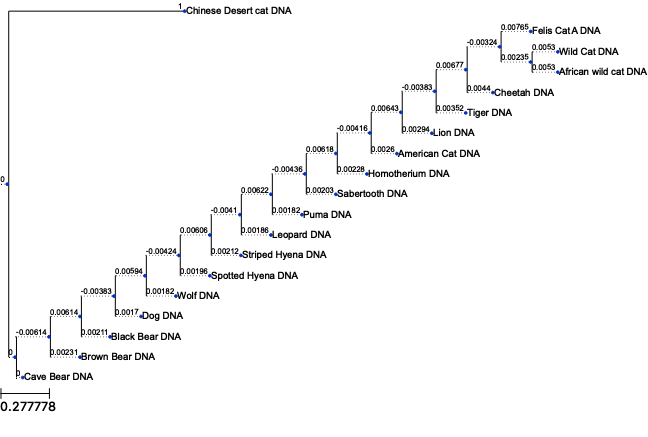

In [94]:
#Tests
#[[0, 5,  4, 7,  6, 8 ],
# [5, 0,  7, 10, 9, 11],
# [4, 7,  0, 7,  6, 8 ],
# [7, 10, 7, 0,  5, 9 ],
# [6, 9,  6, 5,  0, 8 ],
# [8, 11, 8, 9,  8, 0 ]]
distances2 = np.reshape([0, 0, 0, 0, 0, 0, 0,
                        8, 0, 0, 0, 0, 0, 0,
                        8, 8, 0, 0, 0, 0, 0,
                        8, 2, 4, 0, 0, 0, 0,
                        16,8, 4, 8,  0, 0, 0,
                        4, 16,32,4, 8, 0, 0,
                        8, 8, 4, 16,8, 32,0], (7,7))
sequences2 = {'A':[], 'B':[], 'C':[], 'D':[], 'E':[], 'F':[], 'G':[]}

testMat = np.array([[0, 5,  4, 7,  6, 8 ], [5, 0,  7, 10, 9, 11], [4, 7,  0, 7,  6, 8 ], [7, 10, 7, 0,  5, 9 ], [6, 9,  6, 5,  0, 8 ], [8, 11, 8, 9,  8, 0 ]])

testKeys = ["A", "B", "C", "D", "E", "F"]


K = list(resultat.keys());
KE = []
for k in K :
    KE.append([k,int(0),int(1)])
#print(KE)
#print(len(KE))
#print(type(float(KE[0][1])))
#k = str(resultat.keys()) 
testTree = UPGMA(M, KE)

tree = testTree + ';'
t = Tree(tree)
ts = TreeStyle()
ts.show_branch_length = True
t.render('%%inline', w=183, units='mm', tree_style=ts)

**Exercice 8 :** Quelles sont les hypothèses faites par UPGMA ? Semblent-elles respectées dans le cas présent ?

Réponse : On fait l’hypothèse d’horloge moléculaire (arbre ultramétrique). L'hypothese semble respectée

----
## Enracinement de l'arbre

Après avoir utilisé UPGMA pour réaliser votre arbre, l'enracinement s'est normalement fait au poids moyen. 

**Exercice 9 :** Quelle autre méthode est-il possible d'utiliser pour enraciner un arbre ? Pouvez-vous l'utilisez ici ? Si oui, afficher le nouvel arbre.

Réponse : Oui il est possible d utiliser d'autre methode pour enraciner un arbre par exemple avec la méthode d'enrassinement par un groupe exterieur 

In [95]:
# À remplir


----
## Neighbor-joining

Le neighbor-joining est un autre algorithme permettant de calculer un arbre phylogénique à partir d'une matrice de distance. Il a l'avantage de faire moins d'hypothèse qu'UPGMA sur les données (elles ne sont plus forcément ultramétrique) et il donne donc de meilleurs arbres dans presque tout les cas. Vous trouverez un example d'application de cet algorithme [ici](http://www.evolution-textbook.org/content/free/tables/Ch_27/T11_EVOW_Ch27.pdf).

**Exercice 10 :** Implémenter l'algorithme du neighbor-joining, appliquer-le aux données puis enraciner l'arbre.

In [96]:
#step 1 -> renvoit une liste avec les calculs de S
def step1(mat, keys):
    res = np.zeros(len(keys))
    
    for i in range(len(keys)):
        sums = 0
        for j in range(len(keys)):
            sums += mat[i, j]
        res[i] = sums / (len(keys) - 2)
        
    return res

#Recupere le minimum de la matrice passée en paramètre et renvoit la valeur et les indices
def minMat(mat):
    i = 1
    j = 0
    valueMin = mat[1][0]
    
    #Parcours de la matrice actuelle pour trouver le minimum et l'index de cette valeur
    for ligne in range(1, len(mat)):
        for colonne in range(ligne):
            if (valueMin > mat[ligne, colonne] and mat[ligne, colonne] != 0):
                valueMin = mat[ligne, colonne]
                i = ligne
                j = colonne
    #ligne, colonne, value
    return i, j, valueMin 
    
#step 2 -> renvoit les indices de la pair selectionnee
def step2(mat, keys, sumS):
    matPair = np.zeros((len(sumS), len(sumS)))
    
    for i in range(len(sumS)):
        for j in range(len(sumS)):
            if(i == j):
                matPair[i, j] = 0
            else:
                matPair[i, j] = mat[i, j] - sumS[i] - sumS[j]
    
    minl, minc, minv = minMat(matPair) 
    
    return minl, minc, minv, matPair



#Calcul de SA et SB
def step3(mat, keys, sumS, minl, minc):
    SA = (mat[minl, minc] / 2) + ((sumS[minc] - sumS[minl]) / 2)
    SB = (mat[minl, minc] / 2) + ((sumS[minl] - sumS[minc]) / 2)

    return SA, SB


def step4(keys, minl, minc, SA, SB):
    res = np.full(len(keys) - 1, "_", dtype='object')
    
    if (min(minl, minc) == minc):
        res[minc] = "(" + str(keys[minc]) + ":" + str(SA) + ", " + str(keys[minl]) + ":" + str(SB) + ")"
        for i in range(minc):
            res[i] = keys[i]
        for i in range(minc + 1, minl):
            res[i] = keys[i]
        for i in range(minl + 1, len(keys)):
            res[i - 1] = keys[i]
    else:
        res[minl] = "(" + str(keys[minl]) + ":" + str(SB) + ", " + str(keys[minc]) + ":" + str(SA) + ")"
        for i in range(minl):
            res[i] = keys[i]
        for i in range(minl + 1, minc):
            res[i] = keys[i-1]
        for i in range(minc + 1, len(keys)):
            res[i-1] = keys[i-2]
            
    return res


def step5(mat, newKeys, minl, minc):
    res = np.zeros((len(newKeys), len(newKeys)))
    
    if(min(minc, minl) == minl):
        temp = minl
        minl = minc
        minc = temp
        
    #recopie vert
    for i in range(minc):
        for j in range(minc):
            res[i, j] = mat[i, j]
            
    #recopie Jaune
    for i in range(minc + 1, minl):
        for j in range(minc):
            res[i, j] = mat[i, j]
        
    for i in range(minc):
        for j in range(minc + 1, minl):
            res[i, j] = mat[i, j]
            
    for i in range(minc + 1, minl):
        for j in range(minc + 1, minl):
            res[i, j] = mat[i, j]
                
    #decalage
    for i in range(minl + 1, len(newKeys) + 1):
        for j in range(minc):
            res[i - 1, j] = mat[i, j]    
                
    for i in range(minl + 1, len(newKeys) + 1):
        for j in range(minc + 1, minl):
            res[i - 1, j] = mat[i, j]  
                
    for i in range(minl + 1, len(newKeys) + 1):
        for j in range(minl + 1, len(newKeys) + 1):
            res[i - 1, j - 1] = mat[i, j]   
                
    for i in range(minc + 1, minl):
        for j in range(minl + 1, len(newKeys) + 1):
            res[i, j - 1] = mat[i, j]
                
    for i in range(minc):
        for j in range(minl + 1, len(newKeys) + 1):
            res[i, j - 1] = mat[i, j]   
            
            
    #recalcul
    for i in range(len(mat)):
        if i < minl:
            res[minc, i] = (mat[minc, i] + mat[minl, i] - mat[minc, minl]) / 2
        else:
            res[minc, i - 1] = (mat[minc, i] + mat[minl, i] - mat[minc, minl]) / 2
    for i in range(len(mat)):
        if i < minl:
            res[i, minc] = (mat[minc, i] + mat[minl, i] - mat[minc, minl]) / 2
        else:
            res[i - 1, minc] = (mat[minc, i] + mat[minl, i] - mat[minc, minl]) / 2
            
            
    return res
    
    
def NJ(mat, keys):    
    while (len(keys) - 2 > 0):
        s1 = step1(mat, keys)
        s2 = step2(mat, keys, s1)
        s3 = step3(mat, keys, s1, s2[0], s2[1])
        s4 = step4(keys, s2[0], s2[1], s3[0], s3[1])
        s5 = step5(mat, s4, s2[0], s2[1])
        mat = s5
        keys = s4
    
    #Fin
    if (max(len(keys[0]), len(keys[1])) == len(keys[0])):
        res = "(" + str(keys[0]) + ":" + str(1) + ", " + str(keys[1]) + ":" + str(mat[1, 0]) + ")"
    else:
        res = "(" + str(keys[1]) + ":" + str(1) + ", " + str(keys[0]) + ":" + str(mat[1, 0]) + ")"
    return res

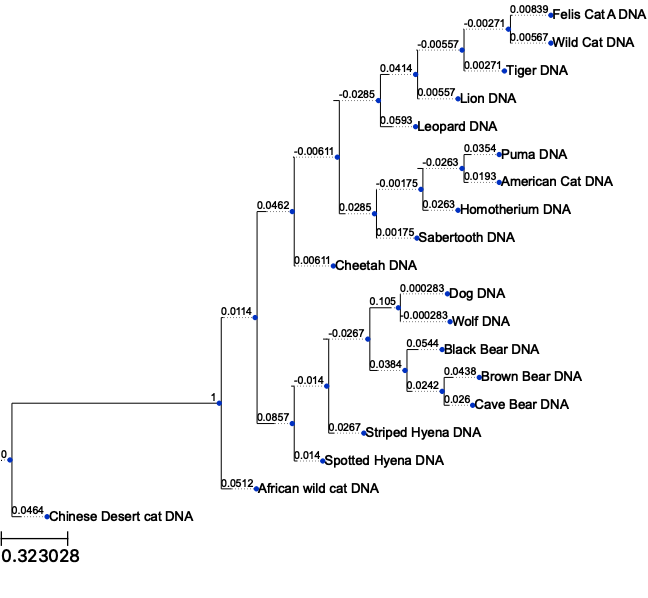

In [101]:
#Tests
#[[0, 5,  4, 7,  6, 8 ],
# [5, 0,  7, 10, 9, 11],
# [4, 7,  0, 7,  6, 8 ],
# [7, 10, 7, 0,  5, 9 ],
# [6, 9,  6, 5,  0, 8 ],
# [8, 11, 8, 9,  8, 0 ]]

testMat = np.array([[0, 5,  4, 7,  6, 8 ], [5, 0,  7, 10, 9, 11], [4, 7,  0, 7,  6, 8 ], [7, 10, 7, 0,  5, 9 ], [6, 9,  6, 5,  0, 8 ], [8, 11, 8, 9,  8, 0 ]])

testKeys = ["A", "B", "C", "D", "E", "F"]

#M=mat_distance(resultat);
K = list(resultat.keys());
#print(resultat.keys())
k = str(resultat.keys()) 

def transpose(M) :
    n=len(M) # nombre de lignes
    m=len(M[0]) # nombre de colonnes
 
    C = [[M[j][i] for j in range(n)] for i in range(m)]
    return C

mat = M + transpose(M)

testTree = NJ(mat, K)
#testTree = NJ(testMat, testKeys)

tree = testTree + ';'
t = Tree(tree)
ts = TreeStyle()
ts.show_branch_length = True
t.render('%%inline', w=183, units='mm', tree_style=ts)

----
## Bootstrap

Le bootstrap est une méthode permettant de calculer la robustesse des branches d'un arbre. Il sagit de recréer un jeu de données artificiel en tirant n positions dans l'alignement des séquences avec remise, n étant la longueur de l'alignement. On recréer un arbre à partir de ces nouvelles données puis on le compare avec l'arbre obtenu avec les données réelles. Si une branche de l'arbre réelle est présente dans l'arbre artificiel, son bootstrap augmente de 1. On répètera la procédure 100 fois afin d'avoir un score sur 100 pour chaque branche.

**Exercice 11 :** Calculer le bootstrap des branches des arbres obtenus avec UPGMA et neighbor-joining.

   voici un squelette de ce qu'on aurait voulu faire

In [100]:
def calculUTO (arbre):
    #va recuperer toutes les branches
    '''ils faut parcourir tout l'arbre pour recuperer les utos
    mais comment les récupérer lorsque l'on a une branche (A-B) relié à la branche C par exemple''' 
    return 0
    
def new_alignement(dico) :
    #va faire le nouvel alignement et calculer la nouvelle matrice
    '''on fait un nouveau dictionnaire avec les nouveaux alignements puis on calcul la nouvelle matrice distance'''
    return 1

def bootstrap(nb_essai, methode):
    #enregistrement de l'arbre original de l'algo neighbor-joining et de ses UTOs
    K = list(resultat.keys());
    new = M + transpose(M)
    Nj = NJ(new, K)
    uto_NJ = calculUTO (Nj)
    
    #enregistrement de l'arbre original de l'algo UPGMA et de ses UTOs
    KE = []
    for k in K :
        KE.append([k,int(0),int(1)])
    Upgma = UPGMA(M, KE)
    uto_Upgma = calculUTO (Upgma)
    
    x= 1 #a def
    y= 1 #a def
    score = np.zeros((x, y)) #buffer de sauvegarde des scores
    
    #calcul de bootstrap
    for i in range (nb_essai) :
        mat = new_alignement(resultat) #calcul de la nouvelle matrice distance
        if methode == "UPGMA" :
            K = list(resultat.keys())
            KE = []
            for k in K :
                KE.append([k,int(0),int(1)])
            a_comparer = UPGMA(mat, KE)
        else :
            K = list(resultat.keys())
            new = mat + transpose(mat)
            a_comparer = NJ(new, K)
            
        uto = calculUTO (a_comparer)
        
        #comparaison des deux UTOs et calcul du score
        
    return score 

----
## Conclusion

**Exercice 12 :** Quelles sont vos conclusions par rapport à l'arbre phylogénique de _smilodon_, _homotherium_ et _M. trumani_(American Cheetah) ? Comparer les deux méthodes. Comment expliquer les caractéristiques morphologiques similaires entre ces trois espèces ? Une réponse détaillée est attendue.

Réponse : Celui qui aura la meilleur score sur l'ensemble de ses branches à la question 11 sera le plus fiable 